# SLT-CE-1: Locally Linear Embedding

<h2 style="background-color:#f0b375;"> Setup </h2>

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn as skl
import numpy as np

from tensorflow.examples.tutorials.mnist import input_data
from sklearn.utils.validation import check_is_fitted

from sklearn.manifold import LocallyLinearEmbedding as SklearnLLE

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


<p style="background-color:#adebad;">
The MNIST data set contains three sets: **mnist.train, mnist.validation, mnist.test**  
Each of them is a numpy array with samples along rows, and pixels along columns.   
The original shape of the images is 28x28 = 784.
</p>

In [3]:
mnist.train.images.shape

(55000, 784)

In [4]:
mnist.validation.images.shape

(5000, 784)

In [5]:
mnist.test.images.shape

(10000, 784)

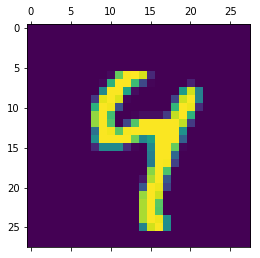

In [6]:
plt.matshow(mnist.train.images[2].reshape(28,28))
plt.show()

<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">
    Shortly recapitulate the Locally Linear Embedding (LLE) algorithm, and the involved formulas.
</p>

Put your markdown text here (it can also do Latex, just put it between two dollar signs! $\sum$)

<p style="background-color:#adebad;">
    Implement the <b>fit method</b> for the template class LocallyLinearEmbedding, according to the contract outlined in its docstring.<br>
    In particular, use the class attribute (variable) names as provided, and introduce new class attributes only if necessary.
</p>

In [106]:
class LocallyLinearEmbedding(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for LLE, compare to `sklearn LLE`_.
    
    Attributes:
        embedding_vectors_ (np.ndarray): Embedding of input X with shape (samples, n_components)
        nbrs_X (e.g. sklearn.neighbors.KDTree): NearestNeighbors (NN) object, stores NN for training set X.
        nbrs_y (e.g. sklearn.neighbors.KDTree): NearestNeighbors (NN) object, stores NN for embedding_vectors_.
        M_ (np.array): Symmetric matrix (samples, samples), used in quadratic form for embedding.
        X_ (np.array): Copy of training set with shape (samples, dim).
    
       .. _`sklearn LLE`: http://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html
    """
    
    def __init__(self, n_components=2, n_neighbors=5, use_sparsity=True, random_state=None, reg=1e-3):
        self.n_neighbors = n_neighbors
        self.n_components = n_components
        self.use_sparsity = use_sparsity
        self.random_state = skl.utils.check_random_state(random_state)
        self.reg = reg
    
    def fit(self, X):
        """Compute LLE embedding of vectors X
        
        First, compute nbrs_X and M_.
        Finally, compute embedding_vectors_.
        
        Args:
            X (np.ndarray): Input array with shape (samples, dim)
        
        Returns:
            self
        """
        self.X_ = np.copy(X)
        self.nbrs_X = skl.neighbors.KDTree(X)
        n_samples = X.shape[0]
        
        # get nearest neighbors indices
        # get +1 and skip first to account for self
        ind = self.nbrs_X.query(X, k=self.n_neighbors+1, return_distance=False)[:, 1:]

        # calculate barycenter weights w
        w = np.empty((n_samples, self.n_neighbors)) # placeholder for weights
        C = np.empty((self.n_neighbors, self.n_neighbors)) # placeholder for covariances
        for i in range(n_samples):
            # populate covariance matrix C
            for j in range(self.n_neighbors):
                for k in range(self.n_neighbors):
                    eta_j = self.X_[ind[i, j]]
                    eta_k = self.X_[ind[i, k]]
                    C[j, k] = np.dot((X[i] - eta_j), (X[i] - eta_k))
            C = C + self.reg * np.eye(*C.shape) # regularize the covariance matrix
            # calculate the weights
            w[i] = np.linalg.solve(C, np.ones((self.n_neighbors)))
            w[i] = w[i] / np.sum(w[i]) # normalize
        
        # Implemented are two ways to compute the eigenproblem. If use_sparsity is
        # specified scipy is imported to exploit the sparsity property of M_. Only
        # the k=self.n_components+1 smallest eigenvalues/eigenvectors are computed.
        # If use_sparsity=False the dense eigensolver of numpy is used.
        if self.use_sparsity:
            import scipy as sp # use scipy for sparse matrix and faster eigen-solver
            # create sparse barycenter graph from weights
            W = sp.sparse.lil_matrix((n_samples, n_samples))
            for i in range(n_samples):
                W[i, ind[i]] = w[i]

            M = sp.sparse.eye(*W.shape) - W
            M = (M.T * M).tocsc()
            self.M_ = M.todense()

            v0 = self.random_state.uniform(-1, 1, M.shape[0])
            evals, evecs = sp.sparse.linalg.eigsh(M, k=self.n_components+1, sigma=0.0, v0=v0)
            self.reconstruction_error_ = np.sum(evals[1:])
            self.embedding_vectors_ = evecs[:, 1:]
        else:
            # create dense barycenter graph from weights
            W = np.zeros((n_samples, n_samples))
            for i in range(n_samples):
                W[i, ind[i]] = w[i]

            M = np.eye(*W.shape) - W
            M = np.dot(M.T, M)
            self.M_ = M

            evals, evecs = np.linalg.eigh(M)
            self.reconstruction_error_ = np.sum(evals[1:self.n_components+1])
            self.embedding_vectors_ = evecs[:, 1:self.n_components+1]
            
        self.nbrs_y = skl.neighbors.KDTree(self.embedding_vectors_)
    
    def transform(self, X):
        """Map new vectors X to embedding space
        
        Use the fitted model to map new vectors to the space with dimension n_components.
        
        Args:
            X (np.ndarray): Input array with shape (new_samples, dim)
            
        Returns:
            y (np.ndarray): Embedded vectors with shape (new_samples, n_components)
        """
        check_is_fitted(self, ["embedding_vectors_", "nbrs_X"])
        
        n_samples = X.shape[0]
        
        # get nearest neighbors indices
        # do not skip first element here (first!=self)
        ind = self.nbrs_X.query(X, k=self.n_neighbors, return_distance=False)

        # calculate barycenter weights w
        w = np.empty((n_samples, self.n_neighbors)) # placeholder for weights
        C = np.empty((self.n_neighbors, self.n_neighbors)) # placeholder for covariances
        for i in range(n_samples):
            # populate covariance matrix C
            for j in range(self.n_neighbors):
                for k in range(self.n_neighbors):
                    eta_j = self.X_[ind[i, j]]
                    eta_k = self.X_[ind[i, k]]
                    C[j, k] = np.dot((X[i] - eta_j), (X[i] - eta_k))
            C = C + self.reg * np.eye(*C.shape) # regularize the covariance matrix
            # calculate the weights
            w[i] = np.linalg.solve(C, np.ones((self.n_neighbors)))
            w[i] = w[i] / np.sum(w[i]) # normalize

        # project into embedding space
        y = np.empty((n_samples, self.n_components))
        for i in range(n_samples):
            y[i] = np.dot(self.embedding_vectors_[ind[i]].T, w[i])
        return y

    def inverse_transform(self, y):
        """Map new vectors y to input space with dimension dim.
        
        Use the fitted model to map vectors y to the original input space.
        
        Args:
            y (np.ndarray): Input array with shape (new_samples, n_components)
            
        Returns:
            X (np.ndarray): Vectors with shape (new_samples, dim)
        """
        check_is_fitted(self, ["embedding_vectors_", "X_", "nbrs_y"])
        
        n_samples = y.shape[0]

        # get nearest neighbors indices
        # do not skip first element here (first!=self)
        ind = self.nbrs_y.query(y, k=self.n_neighbors + 1, return_distance=False)[:, 1:]
        
        # calculate barycenter weights w
        w = np.empty((n_samples, self.n_neighbors)) # placeholder for weights
        C = np.empty((self.n_neighbors, self.n_neighbors)) # placeholder for covariances
        for i in range(n_samples):
            # populate covariance matrix C
            for j in range(self.n_neighbors):
                for k in range(self.n_neighbors):
                    eta_j = self.embedding_vectors_[ind[i, j]]
                    eta_k = self.embedding_vectors_[ind[i, k]]
                    C[j, k] = np.dot((y[i] - eta_j), (y[i] - eta_k))
            C = C + self.reg * np.eye(*C.shape) # regularize the covariance matrix
            # calculate the weights
            w[i] = np.linalg.solve(C, np.ones((self.n_neighbors)))
            w[i] = w[i] / np.sum(w[i]) # normalize
            
        # project into original space
        X = np.empty((n_samples, self.X_.shape[1]))
        for i in range(n_samples):
            X[i] = np.dot(self.X_[ind[i]].T, w[i])
        return X

<p style="background-color:#adebad;">
    Create an instance of your LLE class with default parameters and fit the MNIST validation set. Record the execution time (should be about 30 sec). Furthermore, create an instance of the sklearn LLE class, and fit it with the same parameters. Again record the execution time.  
    Note, the dots should be filled in by you.
</p>

In [110]:
%%time
# use dense eigensolver of numpy
myLLEdense = LocallyLinearEmbedding(use_sparsity=False)
myLLEdense.fit(mnist.validation.images)

CPU times: user 2min 48s, sys: 2.65 s, total: 2min 51s
Wall time: 1min 51s


In [111]:
%%time
# use scipy sparse eigensolver to exploit sparsity property of M_
# the same random_state=42 is used as for the sklearn implementation
# for comparison (this produces the same initial vector v0)
myLLE = LocallyLinearEmbedding(use_sparsity=True, random_state=42)
myLLE.fit(mnist.validation.images)

CPU times: user 47 s, sys: 530 ms, total: 47.5 s
Wall time: 45.7 s


In [112]:
%%time
sklLLE = SklearnLLE(random_state=42)
sklLLE.fit(mnist.validation.images)

CPU times: user 54.5 s, sys: 594 ms, total: 55.1 s
Wall time: 53.4 s


<p style="background-color:#adebad;">
    Plot myLLE.embedding\_vectors\_ and sklLLE.embedding\_vectors\_ in two separate plots.
</p>

In [94]:
def plt_mnist(embedding, of="validation"):
    labels = getattr(mnist, of).labels
    
    if len(labels) != len(embedding):
        raise ValueError("Number of labels does not match number of embeddings")
    
    for label in range(10):
        idx = (labels == label)
        plt.scatter(embedding[idx, 0], embedding[idx, 1], alpha=0.5, label=str(label))
    plt.legend()

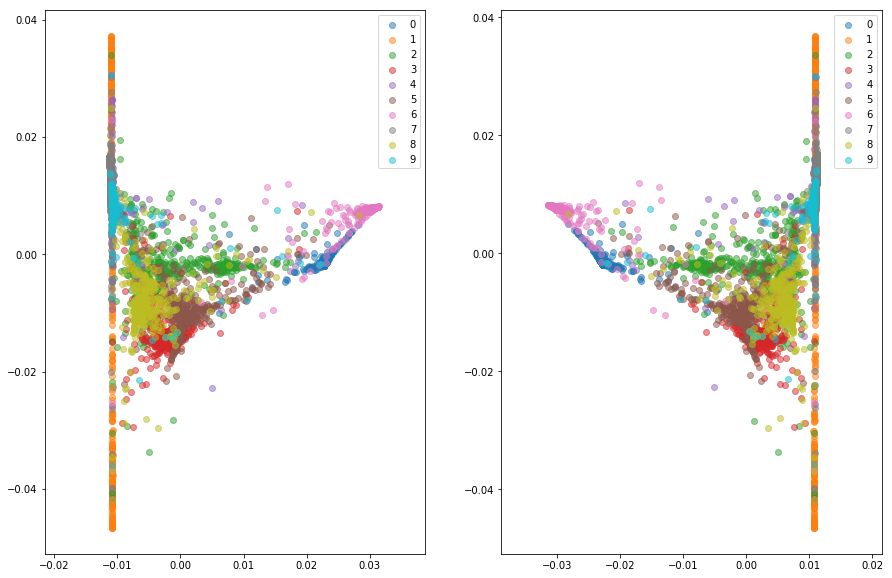

In [109]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt_mnist(sklLLE.embedding_)
plt.subplot(122)
plt_mnist(myLLE.embedding_vectors_)

<h2 style="background-color:#f0b375;"> Section 4.5
<span style=font-size:50%> Complete all problems in this and previous sections to get a 4.5 on this exercise. </span>
</h2>

<p style="background-color:#adebad;">
    <ul style="background-color:#adebad;">
        <li> Implement the <b>transform method</b> for the template class LocallyLinearEmbedding, according to the contract outlined in its docstring.
        </li>
        
        <li>Fit both, myLLE and sklLLE on the MNIST validation set, and use the fitted model to transform the MNIST test set.
        </li>
        
        <li>
            Plot both embeddings in two separate plots for comparison.
        </li>
    </ul>
</p>

In [73]:
%%time
my_embedding = myLLE.transform(mnist.test.images)

CPU times: user 1min 14s, sys: 353 ms, total: 1min 14s
Wall time: 1min 14s


In [74]:
%%time
skl_embedding = sklLLE.transform(mnist.test.images)

CPU times: user 1min 28s, sys: 586 ms, total: 1min 29s
Wall time: 1min 29s


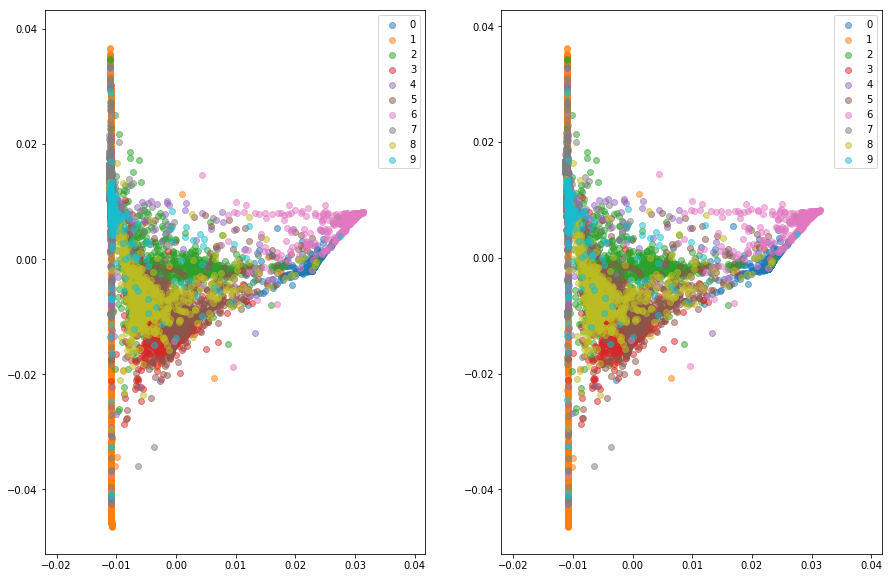

In [75]:
# Put the plots here
plt.figure(figsize=(15,10))
plt.subplot(121)
plt_mnist(skl_embedding, of='test')
plt.subplot(122)
plt_mnist(my_embedding, of='test')

<h2 style="background-color:#f0b375;"> Section 5.0
<span style=font-size:50%> Complete all problems in this and previous sections to get a 5.0 on this exercise. </span>
</h2>

<ul style="background-color:#adebad;">
    <li> Think how you can invert the LLE embedding, and shortly describe your approach.</li>
        <li> Using your approach, implement the <b>inverse_transform method</b> for the template class LocallyLinearEmbedding, according to the contract outlined in its docstring.
        </li>
        <li>
        Use myLLE.transform and myLLE.inverse_transform to embed the first digit of the MNIST training set and then recover it. 
        </li>
       
    </ul>

Put the description of your approach to invert the LLE embedding here.

In [122]:
%%time
myLLE = LocallyLinearEmbedding(random_state=42)
myLLE.fit(mnist.validation.images)

CPU times: user 47.5 s, sys: 575 ms, total: 48 s
Wall time: 46.8 s


In [123]:
input_digits = mnist.train.images[:20]
embedded_digits = myLLE.transform(input_digits)
reconstructed_digits = myLLE.inverse_transform(embedded_digits)

<ul style="background-color:#adebad;">
        <li>
        Plot the original digit and the reconstructed digit for comparison.
        </li>
    </ul>

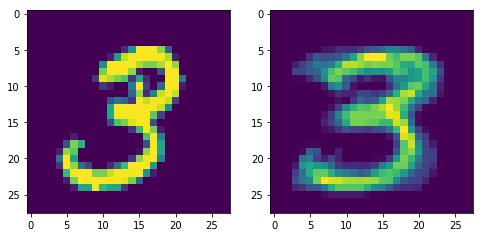

In [124]:
index = 1
plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(input_digits[index].reshape(28,28))
plt.subplot(122)
plt.imshow(reconstructed_digits[index].reshape(28,28))

<h2 style="background-color:#f0b375;"> Section 5.5
<span style=font-size:50%> Complete all problems in this and previous sections to get a 5.5 on this exercise. </span>
</h2>

<ul style="background-color:#adebad;">
        <li>
        Perform a grid search of the reconstruction error, i.e. the sum of the k lowest eigenvalues of matrix M_ (with k=n_components), over the parameters n_neighbors, and n_components.  
        Create a nice 2D heatmap of the results.
        </li>
    </ul>

In [195]:
# do the grid search
n_neighbors_range = 2**np.arange(1, 5)
n_components_range = np.array([2, 3, 4])
n_total = n_components_range.shape[0] * n_neighbors_range.shape[0]
heatmap = np.empty((n_neighbors_range.shape[0], n_components_range.shape[0]))
ctr = 0
for i, n_neighbors in enumerate(n_neighbors_range):
    for j, n_components in enumerate(n_components_range):
        print('grid search [%s/%s]: fitting (n_neighbors=%s, n_components=%s)...' % (
            ctr+1, n_total, n_neighbors, n_components))
        lle_ = LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=n_components)
        lle_.fit(mnist.validation.images)
        heatmap[i, j] = lle_.reconstruction_error_
        ctr += 1

grid search [1/12]: fitting (n_neighbors=2, n_components=2)...
grid search [2/12]: fitting (n_neighbors=2, n_components=3)...
grid search [3/12]: fitting (n_neighbors=2, n_components=4)...
grid search [4/12]: fitting (n_neighbors=4, n_components=2)...
grid search [5/12]: fitting (n_neighbors=4, n_components=3)...
grid search [6/12]: fitting (n_neighbors=4, n_components=4)...
grid search [7/12]: fitting (n_neighbors=8, n_components=2)...
grid search [8/12]: fitting (n_neighbors=8, n_components=3)...
grid search [9/12]: fitting (n_neighbors=8, n_components=4)...
grid search [10/12]: fitting (n_neighbors=16, n_components=2)...
grid search [11/12]: fitting (n_neighbors=16, n_components=3)...
grid search [12/12]: fitting (n_neighbors=16, n_components=4)...


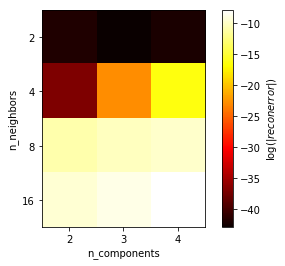

In [200]:
plt.imshow(np.log(np.abs(heatmap)), cmap='hot', interpolation='nearest')
plt.xticks(np.arange(n_components_range.shape[0]), n_components_range)
plt.xlabel('n_components')
plt.yticks(np.arange(n_neighbors_range.shape[0]), n_neighbors_range)
plt.ylabel('n_neighbors')
cb = plt.colorbar()
cb.set_label(r'$\log(|\mathit{reconerror}|)$')

<ul style="background-color:#adebad;">
        <li>
        Create a matrix plot of the matrix M\_.  
        Make sure to permute the rows and columns according to the digit labels, so that you can actually observe the block structure. Also make sure to scale the plot properly, so that you can observe the block structure. What is the origin of the block structure?
        </li>
        <li>
        Plot the spectrum (eigenvalues) of M\_. Can you identify a good cutoff? What could you use the value of the cutoff for?
        </li>
    </ul>

In [208]:
%%time

# compute all eigenvalues and eigenvecs of M_
M_ = myLLE.M_
evals, evecs = np.linalg.eigh(M_)

CPU times: user 1min 44s, sys: 1.74 s, total: 1min 46s
Wall time: 54.8 s


In [463]:
# get sorted index wrt labels of validation set
labels_index = np.argsort(mnist.validation.labels)

# permute the M matrix rows and columns according to sorted index
M_perm = np.array(M_[labels_index][:, labels_index])

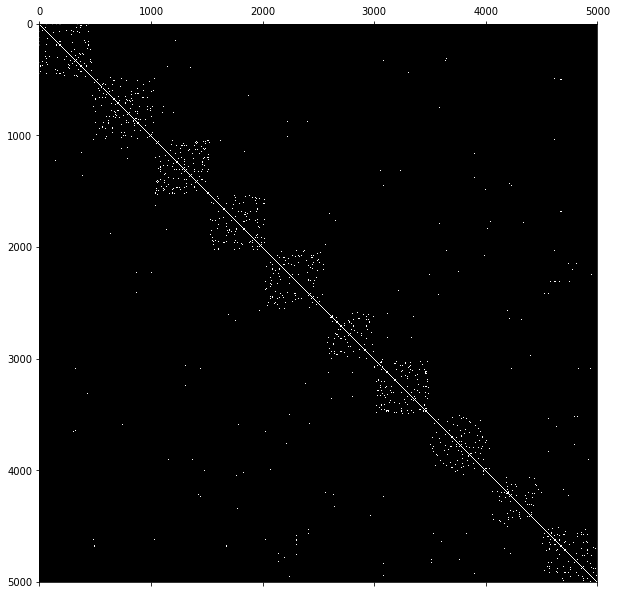

In [465]:
# binarize the matrix to exaggerate block-diagonal structure
# the binarization is taken on the pointwise magnitude of M_
M_perm_bin = skl.preprocessing.binarize(np.abs(M_perm))

plt.figure(figsize=(10, 10))
plt.matshow(M_perm_bin, cmap='gray', fignum=1)

### Remarks:
The rows and columns of $M\_$ correspond to the samples of the training set. The permutation with respect to the digit classes makes sure that similar digits (e.g. digits of the same class) are located back to back in $M\_$. Matrix $M\_$ is a consequence of calculating pairwise dot products between the vectors and covectors of $(I-W)$, which is the identity minus the graph of barycenter weights. Entries $M_{ij} = ((I-W)^T(I-W))_{ij}$ are then non-zero if there is a non-orthogonal component between samples $i$ and $j$ indicating a closeness between the two samples. Since similar samples are located back to back in the permuted matrix $M\_$ above, the block-diagonal pattern can be observed.

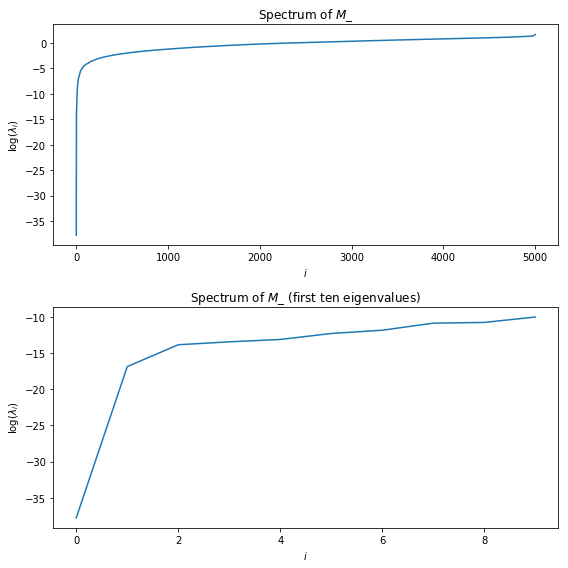

In [236]:
plt.figure(figsize=(8,8))
plt.subplot(211)
plt.plot(np.log(evals))
plt.xlabel('number of eigenvalue')
plt.ylabel(r'$\log(\lambda_i)$')
plt.xlabel(r'$i$')
plt.title(r'Spectrum of $M\_$')
plt.subplot(212)
plt.plot(np.log(evals[:10]))
plt.xlabel('number of eigenvalue')
plt.ylabel(r'$\log(\lambda_i)$')
plt.xlabel(r'$i$')
plt.title(r'Spectrum of $M\_$ (first ten eigenvalues)')
plt.tight_layout()

### Remarks
Plotted above is the spectrum of all the eigenvalues $\lambda_i$ of matrix $M\_$, where $i$ denotes the i-th eigenvalue. The upper panel shows an overview of all eigenvalues while the lower panel shows a detailed plot of the first ten eigenvalues.

A good cutoff could be at $i=2$ where the slope of the spectrum is flatting out, corresponding to selecting the first two eigenvectors (while the zeroth eigenvector is skipped). The cutoff can be used to decide how large `n_components` should be for an optimal lower dimensional embedding.

<h2 style="background-color:#f0b375;"> Section 6.0
<span style=font-size:50%> Complete all problems in this and previous sections to get a 6.0 on this exercise. </span>
</h2>

<ul style="background-color:#adebad;">
        <li>
        Plot the linear interpolation between two digits $x_1,\ x_2$ in the input space compared to the reconstruction along the linear interpolation of their embeddings $y_1, y_2$. More precisely, compare $\lambda x_1 + (1-\lambda) x_2,\ \lambda\in[0,1]$ to $LLE^{-1}\big(\lambda y_1 + (1-\lambda) y_2\big),\ \lambda\in[0,1]$
        </li>
    </ul>

In [141]:
%%time
myLLE = LocallyLinearEmbedding(random_state=42)
myLLE.fit(mnist.validation.images)

CPU times: user 48 s, sys: 560 ms, total: 48.6 s
Wall time: 46.9 s


In [142]:
input_digits = mnist.validation.images[:20]
embedded_digits = myLLE.transform(input_digits)

In [143]:
l = 0.5
index1 = 5
index2 = 6

X1 = input_digits[index1]
X2 = input_digits[index2]

y1 = embedded_digits[index1]
y2 = embedded_digits[index2]

X_inter = np.empty((10, X1.shape[0]))
X_inter_hat = np.empty((10, X1.shape[0]))

for i, l in enumerate(np.linspace(0, 1, 10)):
    X_inter[i] = l*X1 + (1-l)*X2
    y_inter = (l*y1 + (1-l)*y2)
    X_inter_hat[i] = myLLE.inverse_transform(y_inter.reshape(1, -1))

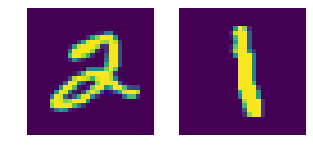

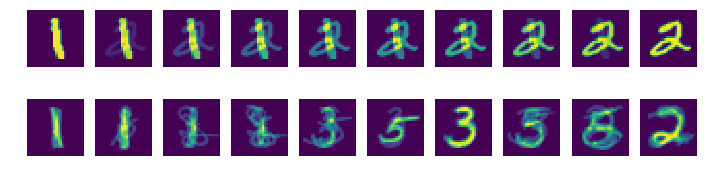

In [144]:
plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(X1.reshape(28, 28))
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(X2.reshape(28, 28))
plt.show()

plt.figure(figsize=(12, 3))
for i in range(10):
    plt.subplot(2, 10, 1+i)
    plt.axis('off')
    plt.imshow(X_inter[i].reshape(28, 28))
for i in range(10):
    plt.subplot(2, 10, 10+(1+i))
    plt.axis('off')
    plt.imshow(X_inter_hat[i].reshape(28, 28))

### Remarks:
Top row shows images $x_1$ and $x_2$. Middle row shows the linear transition between $x_1$ and $x_2$ in the input space. Finally, bottom row shows the inverse transform of the linear transition between corresponding $y_1$ and $y_2$ in the embedding space.

One can see that the transition in the input space simply does a pixel wise interpolation while the transition in the embedding space passes different areas in the embedding space corresponding to certain classes (i.e. digits 5 and 3).

<ul style="background-color:#adebad;">
        <li>
        Select images of digits "6" and a digits "8".  
        Rotate the input images by 360° in steps of 1° and create the embedding of each rotation.  
        Create a nice plot of the respective trajectories in the 2D embedding space (Make sure to use markers for the embeddings, and connect them with a line. Use labels and legends, and add some embeddings of other digits to put the trajectories into context).
        </li>
    </ul>

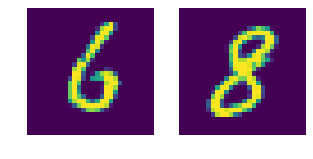

In [85]:
dataset = mnist.test

X1 = dataset.images[dataset.labels==6][3]
X2 = dataset.images[dataset.labels==8][2]

plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(X1.reshape(28, 28))
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(X2.reshape(28, 28))
plt.show()

In [86]:
phi_arr = np.arange(0, 360)
X1_rot = np.vstack(sp.ndimage.rotate(X1.reshape(28, 28), phi, reshape=False).flatten() for phi in phi_arr)
X2_rot = np.vstack(sp.ndimage.rotate(X2.reshape(28, 28), phi, reshape=False).flatten() for phi in phi_arr)

In [87]:
y1_rot = myLLE.transform(X1_rot)
y2_rot = myLLE.transform(X2_rot)

### Remarks
The plots below show trajectories of 360° degree rotations in steps of 1° for the digits 6 and 8 shown above. The trajectories are plotted on top of the embedding plot to be put in perspective.

#### Digit 6
For digit 6 one can see that the embedding for the unaltered digit (0° rotation) is located in the pink cluster (label=6) while the 180° rotated version (resembling a 9) can be found in the cyan cluster (label=9).

#### Digit 8
For digit 8 the unaltered version and the 180° rotated version are both located in the green area (label=8) due to the symmetry of digit 8.

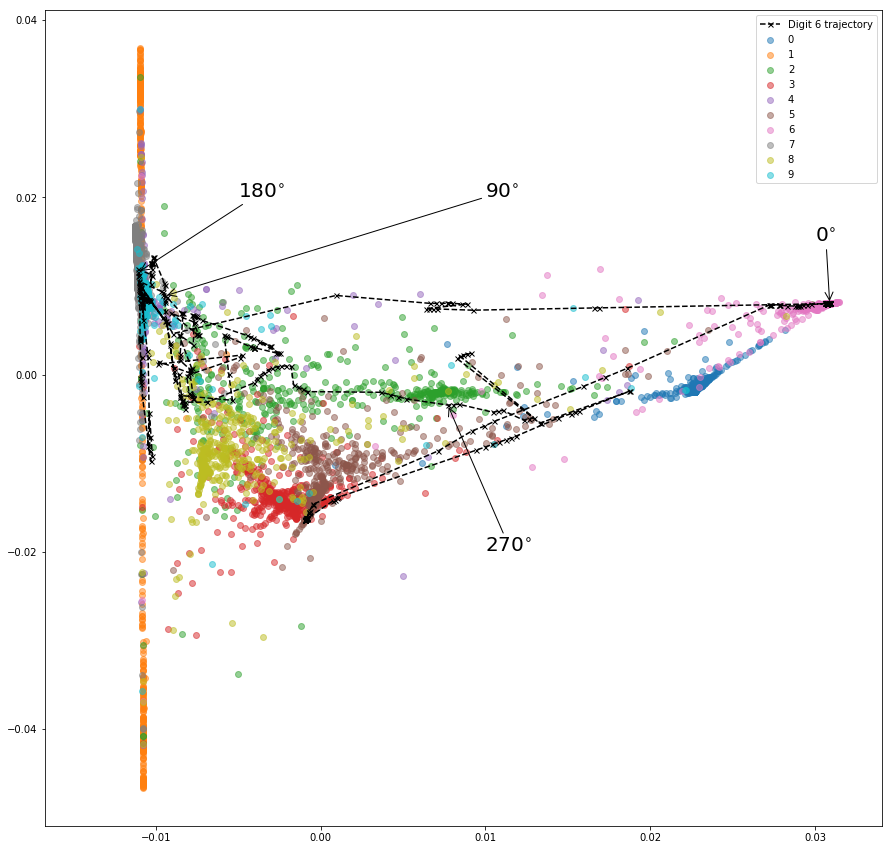

In [88]:
plt.figure(figsize=(15,15))
plt_mnist(myLLE.embedding_vectors_)
plt.plot(y1_rot[:, 0], y1_rot[:, 1], marker='x', c='black', markersize=5, linestyle='--', label='Digit 6 trajectory')
plt.legend()
plt.annotate('$%s^{\circ}$' % phi_arr[0], xy=y1_rot[0],  xycoords='data', xytext=(0.03, 0.015),
             textcoords='data', arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize='20')
plt.annotate('$%s^{\circ}$' % phi_arr[90], xy=y1_rot[90],  xycoords='data', xytext=(0.01, 0.02),
             textcoords='data', arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize='20')
plt.annotate('$%s^{\circ}$' % phi_arr[180], xy=y1_rot[180],  xycoords='data', xytext=(-0.005, 0.02),
             textcoords='data', arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize='20')
plt.annotate('$%s^{\circ}$' % phi_arr[270], xy=y1_rot[270],  xycoords='data', xytext=(0.01, -0.02),
             textcoords='data', arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize='20')
plt.show()

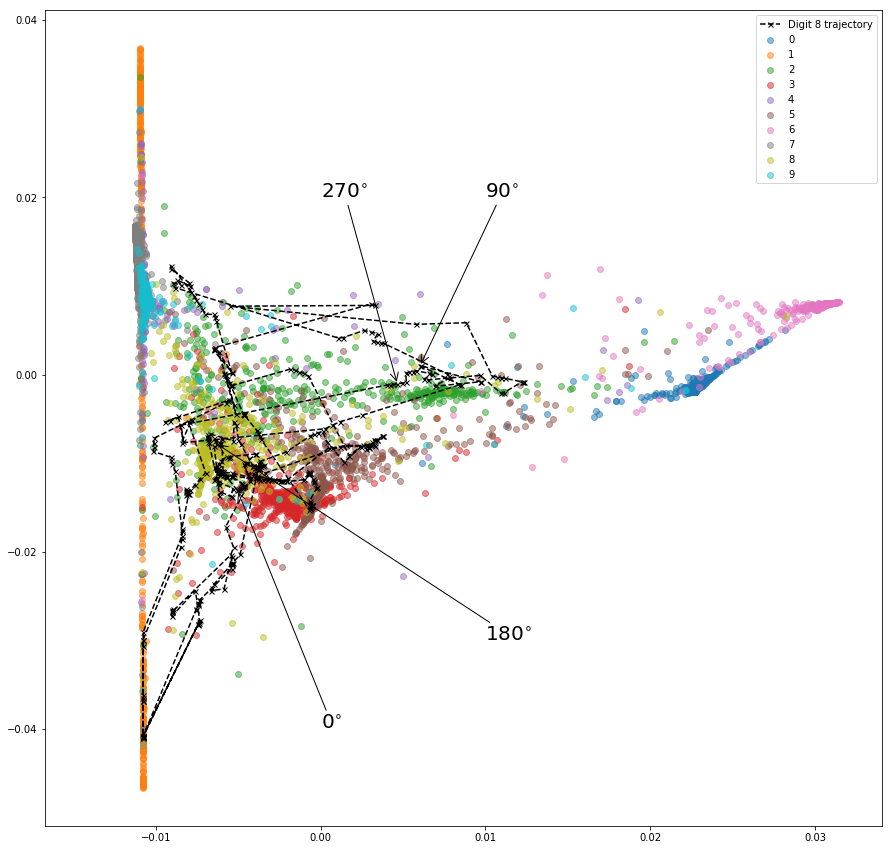

In [89]:
plt.figure(figsize=(15,15))
plt_mnist(myLLE.embedding_vectors_)
plt.plot(y2_rot[:, 0], y2_rot[:, 1], marker='x', c='black', markersize=5, linestyle='--', label='Digit 8 trajectory')
plt.legend()
plt.annotate('$%s^{\circ}$' % phi_arr[0], xy=y2_rot[0],  xycoords='data', xytext=(0.0, -0.04),
             textcoords='data', arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize='20')
plt.annotate('$%s^{\circ}$' % phi_arr[90], xy=y2_rot[90],  xycoords='data', xytext=(0.01, 0.02),
             textcoords='data', arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize='20')
plt.annotate('$%s^{\circ}$' % phi_arr[180], xy=y2_rot[180],  xycoords='data', xytext=(0.01, -0.03),
             textcoords='data', arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize='20')
plt.annotate('$%s^{\circ}$' % phi_arr[270], xy=y2_rot[270],  xycoords='data', xytext=(0.0, 0.02),
             textcoords='data', arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize='20')
plt.show()